In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

In [260]:
data = pd.read_csv('data/historic_demand_2009_2024_noNaN.csv')
data['settlement_date'] = pd.to_datetime(data['settlement_date'])

display(data.head())
display(data.info())
display(data.isna().sum())

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270112 entries, 0 to 270111
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   settlement_date            270112 non-null  datetime64[ns]
 1   settlement_period          270112 non-null  int64         
 2   period_hour                270112 non-null  object        
 3   nd                         270112 non-null  int64         
 4   tsd                        270112 non-null  int64         
 5   england_wales_demand       270112 non-null  int64         
 6   embedded_wind_generation   270112 non-null  int64         
 7   embedded_wind_capacity     270112 non-null  int64         
 8   embedded_solar_generation  270112 non-null  int64         
 9   embedded_solar_capacity    270112 non-null  int64         
 10  non_bm_stor                270112 non-null  int64         
 11  pump_storage_pumping       270112 non-null  int64   

None

settlement_date              0
settlement_period            0
period_hour                  0
nd                           0
tsd                          0
england_wales_demand         0
embedded_wind_generation     0
embedded_wind_capacity       0
embedded_solar_generation    0
embedded_solar_capacity      0
non_bm_stor                  0
pump_storage_pumping         0
ifa_flow                     0
ifa2_flow                    0
britned_flow                 0
moyle_flow                   0
east_west_flow               0
nemo_flow                    0
is_holiday                   0
dtype: int64

In [261]:
data.set_index("settlement_date", inplace=True)

data = data.asfreq('30min')

data.loc[data.england_wales_demand < 10000, "england_wales_demand"] = 0.0
data['england_wales_demand'] = data['england_wales_demand'].replace(0.0, np.nan)

# fill missing values by propagating the last valid observation forward
data.ffill(inplace=True)

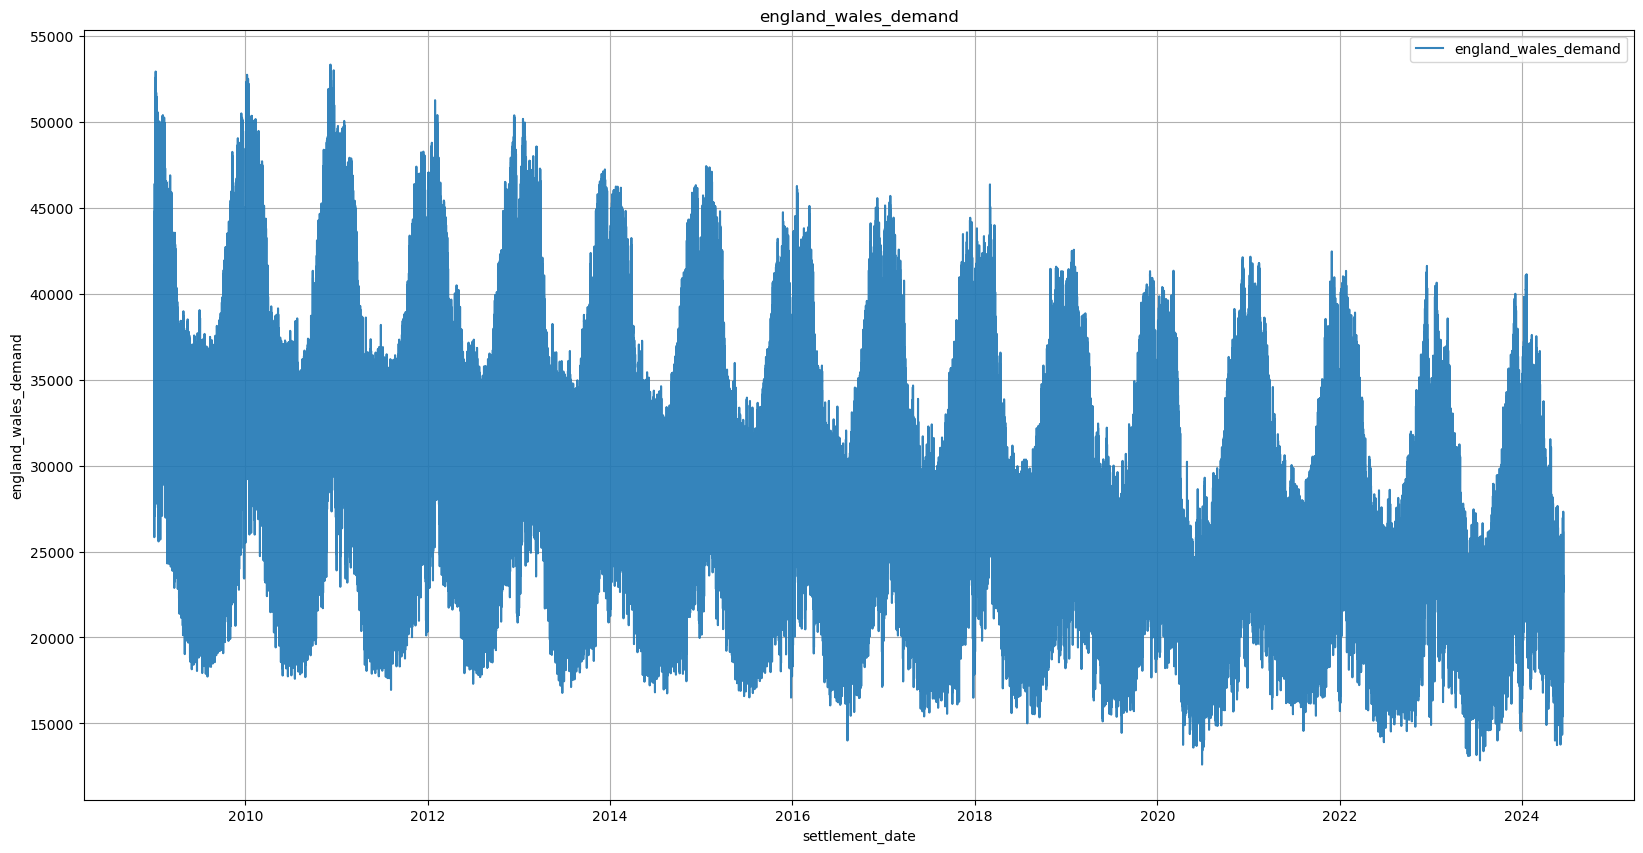

In [262]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='settlement_date', y="england_wales_demand", data=data, label="england_wales_demand", alpha = 0.9) 
plt.title("england_wales_demand")
plt.grid(True)
plt.legend()
plt.plot();

## Monthly Trends

In [275]:
df_demand = data[['england_wales_demand']]

df_demand_monthly = df_demand.resample("MS").sum()
df_demand_monthly = df_demand_monthly.iloc[:-1]

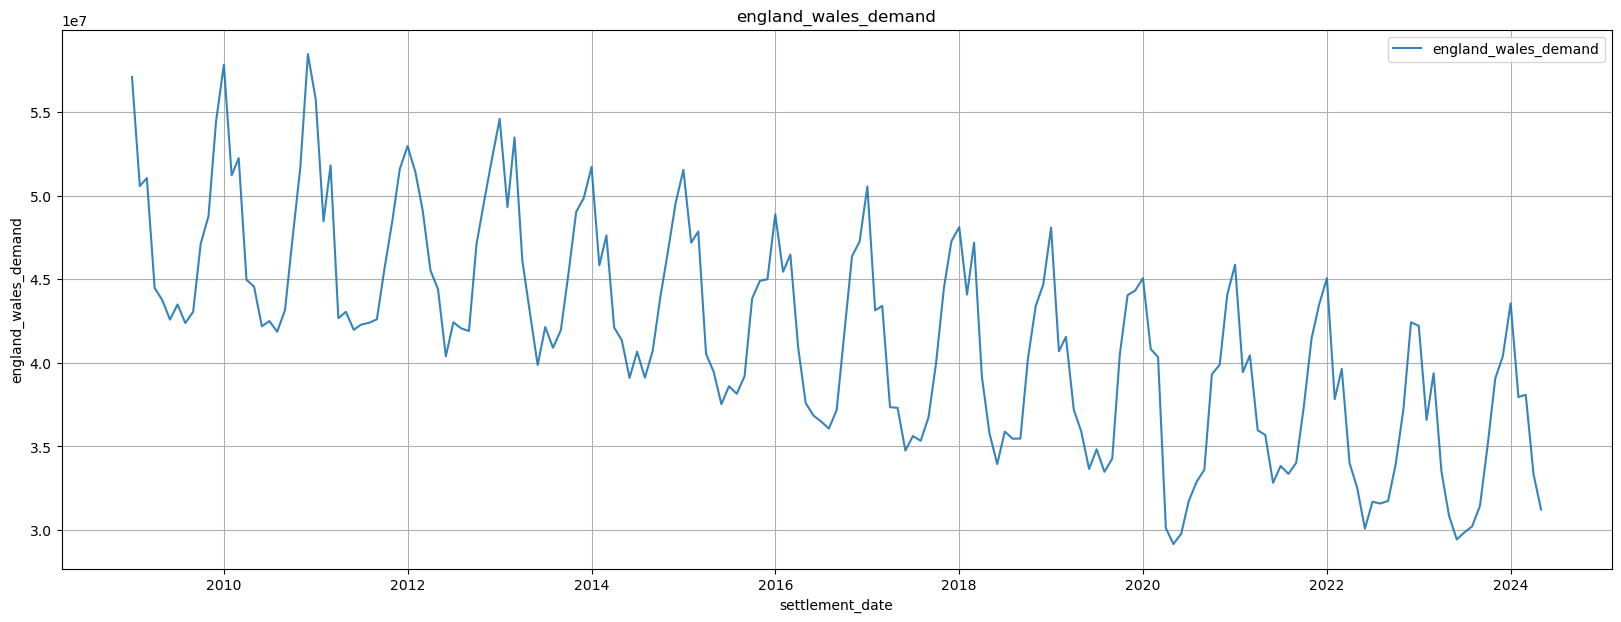

In [276]:
plt.figure(figsize=(20, 7))
sns.lineplot(x='settlement_date', y="england_wales_demand", data=df_demand_monthly, label="england_wales_demand", alpha = 0.9) 
plt.title("england_wales_demand")
plt.grid(True)
plt.legend()
plt.plot();

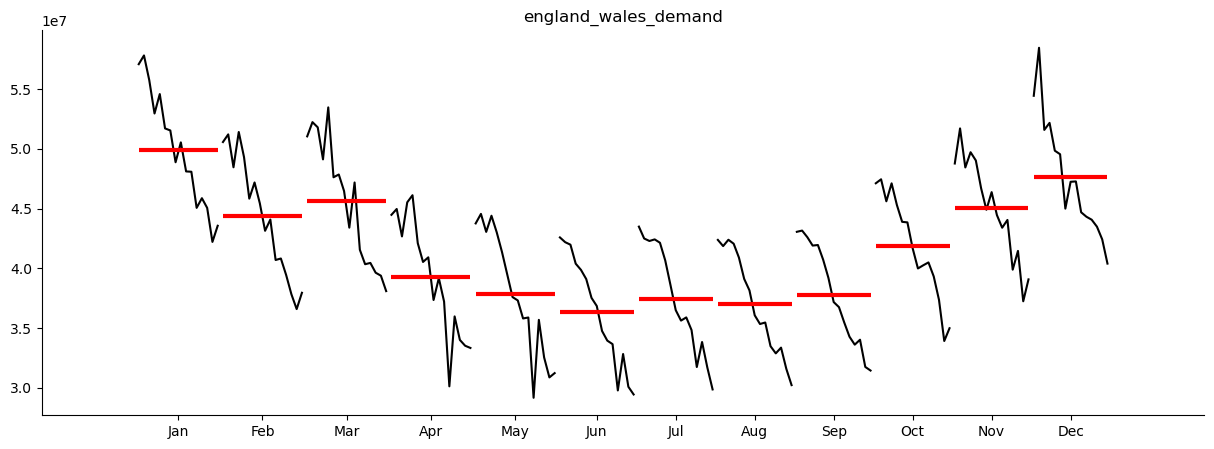

In [277]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(df_demand_monthly["england_wales_demand"], ax=plt.gca())

plt.title("england_wales_demand")
sns.despine()
plt.show()

In [278]:
df_demand_monthly

,england_wales_demand
settlement_date,
2009-01-01,57084786.0
2009-02-01,50568667.0
2009-03-01,51043547.0
2009-04-01,44476006.0
2009-05-01,43757738.0
...,...
2024-01-01,43561870.0
2024-02-01,37952422.0
2024-03-01,38091473.0


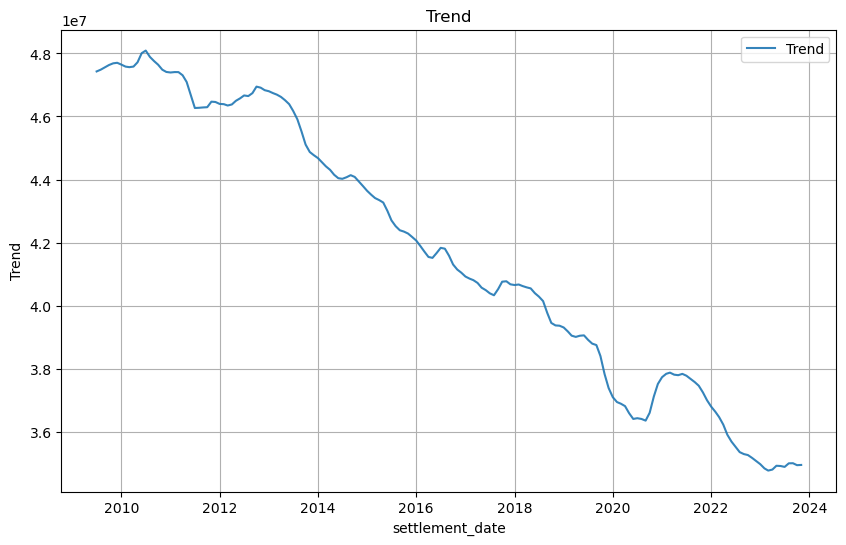

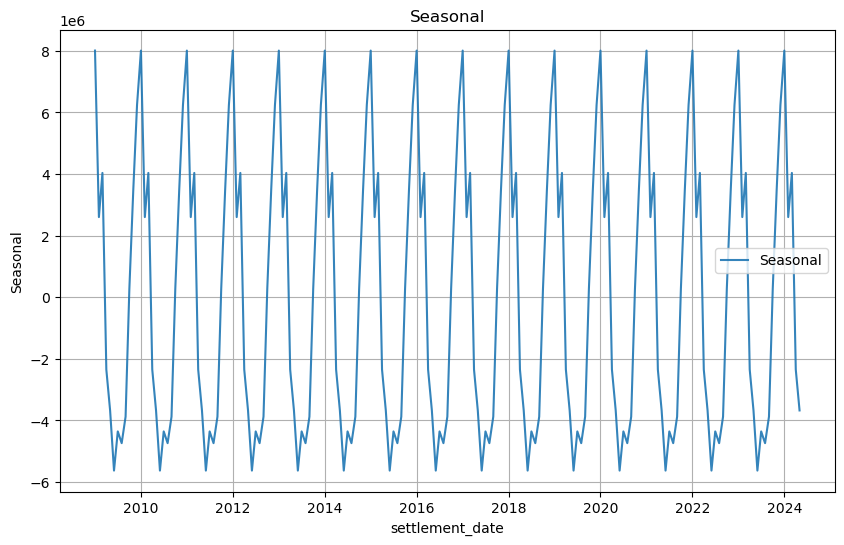

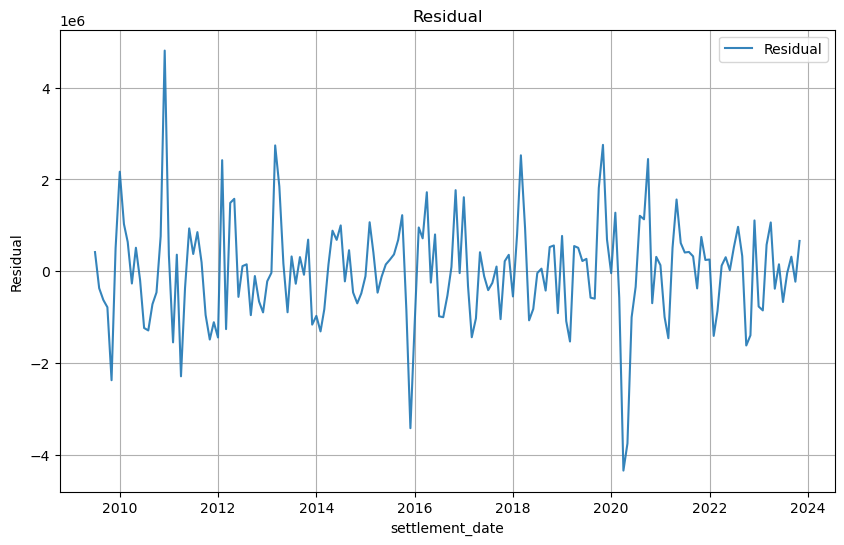

In [279]:
result = seasonal_decompose(df_demand_monthly, model='additive')  # or use model='multiplicative'

# add the decomposition data
df_demand_monthly.insert(1, "Trend", result.trend)
df_demand_monthly.insert(2, "Seasonal", result.seasonal)
df_demand_monthly.insert(3, "Residual", result.resid)

cols = ["Trend", "Seasonal", "Residual"]

for i, col in enumerate(cols):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='settlement_date', y=col, data=df_demand_monthly, label=col, alpha = 0.9) 
    plt.title(col)
    plt.grid(True)
    plt.legend()
    plt.plot();

## Hourly

In [223]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270864 entries, 2009-01-01 00:00:00 to 2024-06-13 23:30:00
Freq: 30min
Data columns (total 1 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   england_wales_demand  270864 non-null  float64
dtypes: float64(1)
memory usage: 4.1 MB


In [281]:
df_demand_hourly = df_demand.resample("h").sum()
# df_demand_hourly = df_demand_monthly.iloc[:-1]

In [284]:
df_demand_hourly[-1000:]

,england_wales_demand
settlement_date,
2024-05-03 08:00:00,54209.0
2024-05-03 09:00:00,56016.0
2024-05-03 10:00:00,55737.0
2024-05-03 11:00:00,55950.0
2024-05-03 12:00:00,55465.0
...,...
2024-06-13 19:00:00,52737.0
2024-06-13 20:00:00,50996.0
2024-06-13 21:00:00,48331.0


In [8]:
weather_data

{'queryCost': 48,
 'latitude': 51.5064,
 'longitude': -0.12721,
 'resolvedAddress': 'United Kingdom',
 'address': 'UK',
 'timezone': 'Europe/London',
 'tzoffset': 1.0,
 'days': [{'datetime': '2024-07-11',
   'datetimeEpoch': 1720652400,
   'tempmax': 22.6,
   'tempmin': 13.3,
   'temp': 18.2,
   'feelslikemax': 22.6,
   'feelslikemin': 13.3,
   'feelslike': 18.2,
   'dew': 10.5,
   'humidity': 63.2,
   'precip': 0.0,
   'precipprob': 0.0,
   'precipcover': 0.0,
   'preciptype': None,
   'snow': 0.0,
   'snowdepth': 0.0,
   'windgust': 35.6,
   'windspeed': 21.9,
   'winddir': 269.2,
   'pressure': 1016.7,
   'cloudcover': 66.5,
   'visibility': 10.0,
   'solarradiation': 256.8,
   'solarenergy': 22.3,
   'uvindex': 9.0,
   'sunrise': '04:56:59',
   'sunriseEpoch': 1720670219,
   'sunset': '21:14:43',
   'sunsetEpoch': 1720728883,
   'moonphase': 0.18,
   'conditions': 'Partially cloudy',
   'description': 'Becoming cloudy in the afternoon.',
   'icon': 'partly-cloudy-day',
   'stations

In [35]:
import requests
from datetime import datetime, timedelta
import json

## `Get data`

In [16]:
def daterange(start_date, end_date, delta):
    current = start_date
    while current < end_date:
        yield current
        current += delta

def fetch_weather_data(start_date, end_date, api_key):
    base_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
    location = "UK"
    params = {
        "unitGroup": "metric",
        "include": "hours",
        "key": api_key,
        "contentType": "json"
    }
    url = f"{base_url}{location}/{start_date}/{end_date}"
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to retrieve data:", response.status_code, response.text)
        return None

def main(api_key):
    # 2009-01-01
    start_period = datetime(2009, 1, 1)
    # 2024-05-01
    end_period = datetime(2024, 5, 1)
    delta = timedelta(days=30)  # Adjust based on API limit, e.g., 30 days
    all_weather_data = []  # List to store all the weather data

    for start in daterange(start_period, end_period, delta):
        end = min(start + delta, end_period)
        weather_data = fetch_weather_data(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"), api_key)
        
        if weather_data:
            all_weather_data.append(weather_data)  # Add the fetched data to the list
            print(f"Weather data retrieved for period {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}.")
        else:
            print(f"Failed to fetch weather data for period {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}.")

    # Optionally save the data to a file
    with open('weather_data_full.json', 'w') as f:
        import json
        json.dump(all_weather_data, f, indent=4)

    print("All weather data has been saved to 'weather_data_full.json'.")

if __name__ == "__main__":
    api_key = 'YBH5XURJGFMTCKTR47KY5KYH9'  # Replace with your actual API key
    main(api_key)


Weather data retrieved for period 2009-01-01 to 2009-01-31.
Weather data retrieved for period 2009-01-31 to 2009-03-02.
Weather data retrieved for period 2009-03-02 to 2009-04-01.
Weather data retrieved for period 2009-04-01 to 2009-05-01.
Weather data retrieved for period 2009-05-01 to 2009-05-31.
Weather data retrieved for period 2009-05-31 to 2009-06-30.
Weather data retrieved for period 2009-06-30 to 2009-07-30.
Weather data retrieved for period 2009-07-30 to 2009-08-29.
Weather data retrieved for period 2009-08-29 to 2009-09-28.
Weather data retrieved for period 2009-09-28 to 2009-10-28.
Weather data retrieved for period 2009-10-28 to 2009-11-27.
Weather data retrieved for period 2009-11-27 to 2009-12-27.
Weather data retrieved for period 2009-12-27 to 2010-01-26.
Weather data retrieved for period 2010-01-26 to 2010-02-25.
Weather data retrieved for period 2010-02-25 to 2010-03-27.
Weather data retrieved for period 2010-03-27 to 2010-04-26.
Weather data retrieved for period 2010-0

## `Parse the saved data`

In [70]:
weather_data[0]['stations'].keys()

dict_keys(['03769099999', '03772099999', '03672099999', '03781099999'])

In [74]:
weather_data[0]['stations']['03781099999']

{'distance': 23178.0,
 'latitude': 51.3,
 'longitude': -0.083,
 'useCount': 0,
 'id': '03781099999',
 'name': 'KENLEY AIRFIELD, UK',
 'quality': 100,
 'contribution': 0.0}

In [64]:
weather_data[0]['days'][0]['sunset']

'16:02:16'

In [54]:
weather_data[0].keys()

dict_keys(['queryCost', 'latitude', 'longitude', 'resolvedAddress', 'address', 'timezone', 'tzoffset', 'days', 'stations'])

In [36]:
def read_weather_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def analyze_hourly_weather_data(data):
    # Initialize lists to store hourly data
    hourly_data = []

    for period in data:
        if 'days' in period:
            for day in period['days']:
                day_date = day['datetime']  # Extract the date of the day
                if 'hours' in day:
                    for hour in day['hours']:
                        # Append each hour's data with the corresponding date
                        hourly_data.append({
                            'date': day_date,  # Include the date of the day
                            'datetime': hour['datetime'],
                            'temperature': hour.get('temp', 'No data'),
                            'conditions': hour.get('conditions', 'No data')
                            'precip': hour.get('precip', 'No data'),
                        })
    return hourly_data

# Load the weather data
weather_data = read_weather_data('weather_data_full.json')
# Get hourly weather data
hourly_weather = analyze_hourly_weather_data(weather_data)


In [37]:
hourly_weather_df = pd.DataFrame(hourly_weather)
hourly_weather_df['datetime'] = pd.to_datetime(hourly_weather_df['date'] + ' ' + hourly_weather_df['datetime'])
hourly_weather_df.drop(columns=['date'], inplace=True)
hourly_weather_df

,date,datetime,temperature,conditions
0,2009-01-01,00:00:00,0.1,Overcast
1,2009-01-01,01:00:00,0.2,Overcast
2,2009-01-01,02:00:00,0.1,Overcast
3,2009-01-01,03:00:00,0.2,Overcast
4,2009-01-01,04:00:00,0.2,Overcast
...,...,...,...,...
138858,2024-05-01,19:00:00,18.4,Overcast
138859,2024-05-01,20:00:00,17.4,Overcast
138860,2024-05-01,21:00:00,16.2,Overcast
138861,2024-05-01,22:00:00,15.6,Partially cloudy


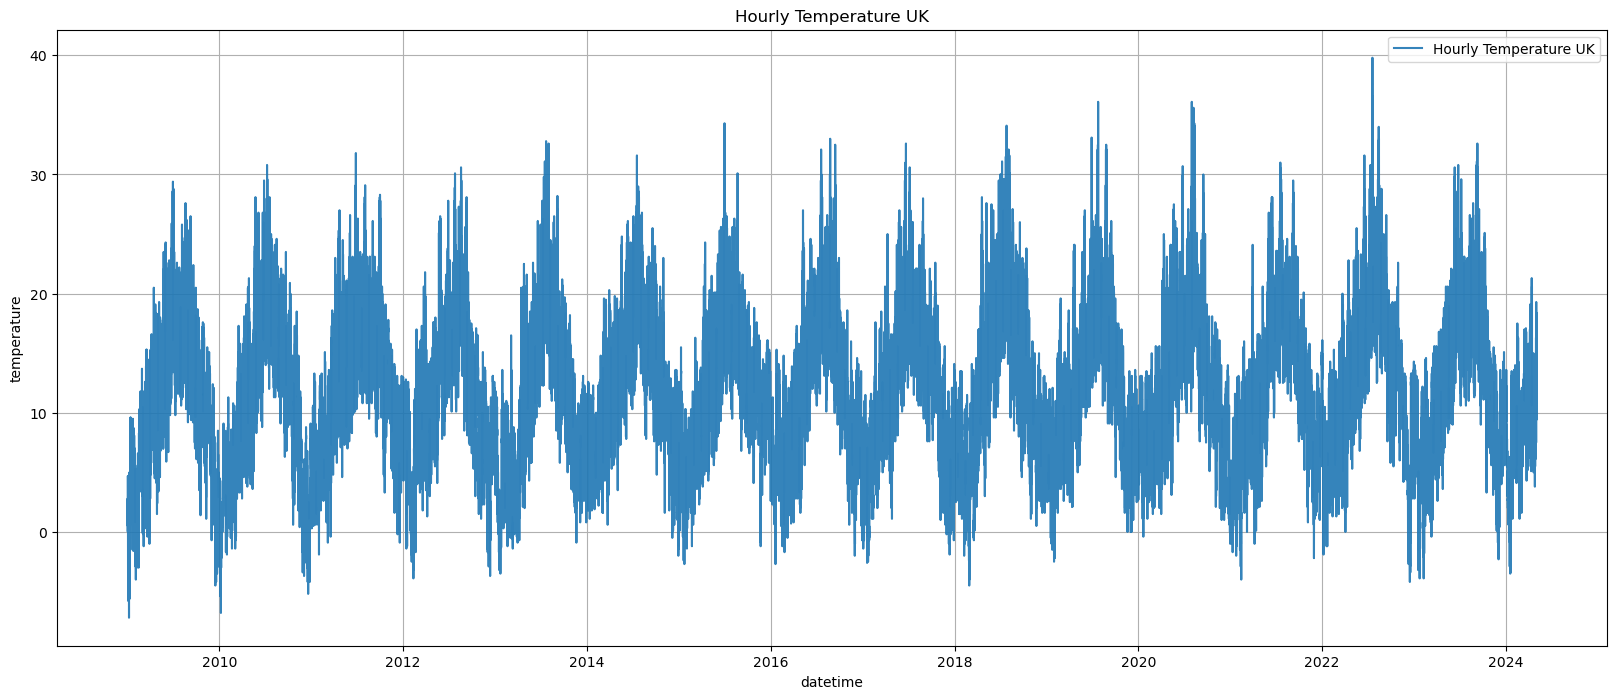

In [65]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='datetime', y="temperature", data=hourly_weather_df, label="Hourly Temperature UK", alpha = 0.9) 
plt.title("Hourly Temperature UK")
plt.grid(True)
plt.legend()
plt.plot();